We begin by importing the relevant libraries to be used.

In [372]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns #data visualization
sns.set()
import random 
import itertools

from scipy.cluster.vq import kmeans, vq, whiten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 5000)

Next, we import the datasets to be analyzed; in our case, we have the list of Pokemon with relevant stats as well as their combat stats.

In [373]:
url = 'https://raw.githubusercontent.com/avasconez/M637-Project-Sp21/main/pokemon%20(1).csv'
pokemon = pd.read_csv(url,error_bad_lines = False)
pokemon = pokemon.rename(index=str, columns={"#": "Number"})
pokemon.set_index('Number', inplace = True)

pokemon.head(5)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
Number,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [374]:
pokemon.count()

Name          799
Type 1        800
Type 2        414
HP            800
Attack        800
Defense       800
Sp. Atk       800
Sp. Def       800
Speed         800
Generation    800
Legendary     800
dtype: int64

In [375]:
url2 = 'https://raw.githubusercontent.com/avasconez/M637-Project-Sp21/main/combats.csv'
combat = pd.read_csv(url2,error_bad_lines = False)

combat.head(5)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


To make sure our datasets our clean and have all relevant information, we perform the following:

In [376]:
pokemon.isnull().sum()

Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [377]:
combat.isnull().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

Before continuing, we need to determine the missing Pokemon name. 

In [378]:
print(pokemon[pokemon['Name'].isnull()])

       Name    Type 1 Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
Number                                                                       
63      NaN  Fighting    NaN  65     105       60       60       70     95   

        Generation  Legendary  
Number                         
63               1      False  


Using an online Pokedex, we find and include Primeape as the missing item.

In [379]:
pokemon['Name'][63] = "Primeape"

Next, we work on finding more relevant data than just what is provided: ie, win percentage. This will be used for visualization and training purposes.

In [380]:
# calculate the win % of each pokemon 
# add the calculation to the pokemon dataset 
total_Wins = combat.Winner.value_counts()
# get the number of wins for each pokemon
numberOfWins = combat.groupby('Winner').count()

#both methods produce the same results
countByFirst = combat.groupby('Second_pokemon').count()
countBySecond = combat.groupby('First_pokemon').count()
print("Looking at the dimensions of our dataframes")
print("Count by first winner shape: " + str(countByFirst.shape))
print("Count by second winner shape: " + str(countBySecond.shape))
print("Total Wins shape : " + str(total_Wins.shape))

Looking at the dimensions of our dataframes
Count by first winner shape: (784, 2)
Count by second winner shape: (784, 2)
Total Wins shape : (783,)


Notice that there is one pokemon who didn't win a single fight. Just for fun, let's find out who that is.

In [381]:
find_losing_pokemon= np.setdiff1d(countByFirst.index.values, numberOfWins.index.values)-1 #offset because the index and number are off by one
losing_pokemon = pokemon.iloc[find_losing_pokemon[0],]
print(losing_pokemon)

Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
Name: 231, dtype: object


In [382]:
numberOfWins = numberOfWins.sort_index()
numberOfWins['Total Fights'] = countByFirst.Winner + countBySecond.Winner
numberOfWins['Win Percentage']= numberOfWins.First_pokemon/numberOfWins['Total Fights']

# merge the winning dataset and the original pokemon dataset
results2 = pd.merge(pokemon, numberOfWins, right_index = True, left_on='Number')
results3 = pd.merge(pokemon, numberOfWins, left_on='Number', right_index = True, how='left')

In [383]:
#subset the dataframe where pokemon win percent is NaN
results3[results3['Win Percentage'].isnull()]

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
Number,,,,,,,,,,,,,,,
12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,NaN,NaN,NaN,NaN
33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,NaN,NaN,NaN,NaN
46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,NaN,NaN,NaN,NaN
66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,NaN,NaN,NaN,NaN
78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,NaN,NaN,NaN,NaN
90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,NaN,NaN,NaN,NaN
144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,NaN,NaN,NaN,NaN
183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,NaN,NaN,NaN,NaN
231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,NaN,NaN,NaN,NaN


We find the top 10 with the worst win percentage and then the top 10 with the best:

In [384]:
results3[np.isfinite(results3['Win Percentage'])].sort_values(by = ['Win Percentage']).head(10)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
Number,,,,,,,,,,,,,,,
290,Silcoon,Bug,NaN,50,35,55,25,25,15,3,False,3.0,3.0,138.0,0.021739
190,Togepi,Fairy,NaN,35,20,65,40,65,20,2,False,3.0,3.0,122.0,0.024590
639,Solosis,Psychic,NaN,45,30,40,105,50,20,5,False,4.0,4.0,129.0,0.031008
237,Slugma,Fire,NaN,40,40,40,70,40,20,2,False,4.0,4.0,123.0,0.032520
577,Munna,Psychic,NaN,76,25,45,67,55,24,5,False,5.0,5.0,128.0,0.039062
189,Igglybuff,Normal,Fairy,90,30,15,40,20,15,2,False,5.0,5.0,115.0,0.043478
395,Wynaut,Psychic,NaN,95,23,48,23,48,23,3,False,6.0,6.0,130.0,0.046154
210,Wooper,Water,Ground,55,45,45,25,25,15,2,False,6.0,6.0,125.0,0.048000
292,Cascoon,Bug,NaN,50,35,55,25,25,15,3,False,7.0,7.0,133.0,0.052632


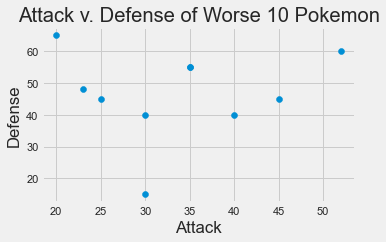

In [385]:
results4 = results3.sort_values(by = ['Win Percentage'])
last_ten = results4.iloc[0:10]
att_last = last_ten.loc[:,"Attack"]
def_last = last_ten.loc[:,"Defense"]

plt.figure(figsize = (5,3))
plt.scatter(att_last, def_last)
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.title("Attack v. Defense of Worse 10 Pokemon")
plt.show()

In [386]:
results3[np.isfinite(results3['Win Percentage'])].sort_values(by = ['Win Percentage'], ascending = False ).head(10)

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
Number,,,,,,,,,,,,,,,
155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False,127.0,127.0,129.0,0.984496
513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False,116.0,116.0,119.0,0.974790
704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,5,True,121.0,121.0,125.0,0.968000
20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False,115.0,115.0,119.0,0.966387
154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False,136.0,136.0,141.0,0.964539
477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False,124.0,124.0,129.0,0.961240
727,Greninja,Water,Dark,72,95,67,103,71,122,6,False,122.0,122.0,127.0,0.960630
717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False,118.0,118.0,123.0,0.959350
165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,119.0,119.0,125.0,0.952000


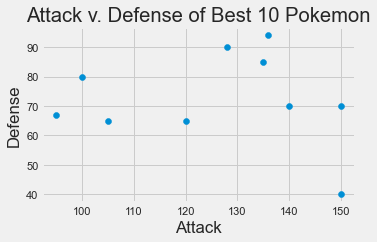

In [387]:
results5 = results3.sort_values(by = ['Win Percentage'], ascending = False)
best_ten = results5.iloc[0:10]
att_best = best_ten.loc[:,"Attack"]
def_best = best_ten.loc[:,"Defense"]

plt.figure(figsize = (5,3))
plt.scatter(att_best, def_best)
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.title("Attack v. Defense of Best 10 Pokemon")
plt.show()

In [388]:
results3.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,First_pokemon,Second_pokemon,Total Fights,Win Percentage
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,783.000000,783.000000,783.000000,783.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,63.856960,63.856960,127.541507,0.501538
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,32.925941,32.925941,11.397402,0.254993
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,3.000000,3.000000,92.000000,0.021739
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,36.000000,36.000000,120.000000,0.284228
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,62.000000,62.000000,128.000000,0.491071
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,91.000000,91.000000,135.000000,0.717644
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,152.000000,152.000000,164.000000,0.984496


In [389]:
results3.groupby('Type 1').agg({"Win Percentage": "mean"}).sort_values(by = "Win Percentage")

,Win Percentage
Type 1,
Fairy,0.329300
Rock,0.404852
Steel,0.424529
Poison,0.433262
Bug,0.439006
Ice,0.439604
Grass,0.440364
Water,0.469357
Fighting,0.475616


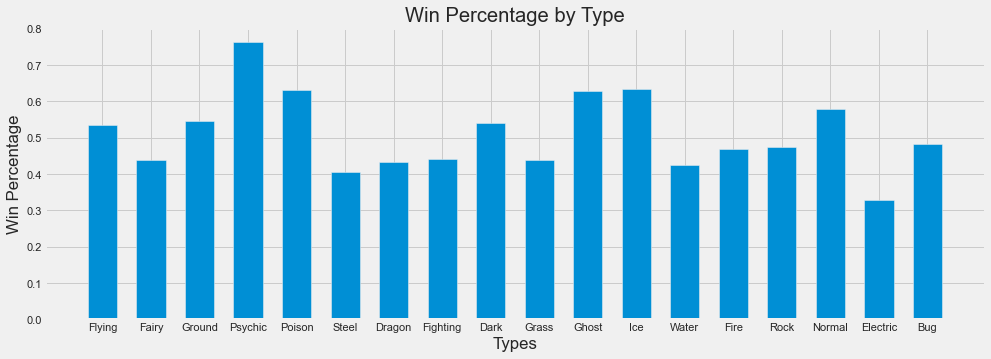

In [390]:
results6 = results3.groupby('Type 1').agg({"Win Percentage": "mean"})
type_wins =  dict(results6['Win Percentage'].value_counts())
type_wins_p = type_wins.keys() # No of pokemon in each generation

fig2 = plt.figure(figsize = (15,5))

plt.bar(types, type_wins_p, width = 0.6)
plt.xlabel("Types")
plt.ylabel("Win Percentage")
plt.title("Win Percentage by Type")
plt.show()

We now begin the data visualization portion of the project.  First, we aim to see the frequency of both types seen in the dataset.

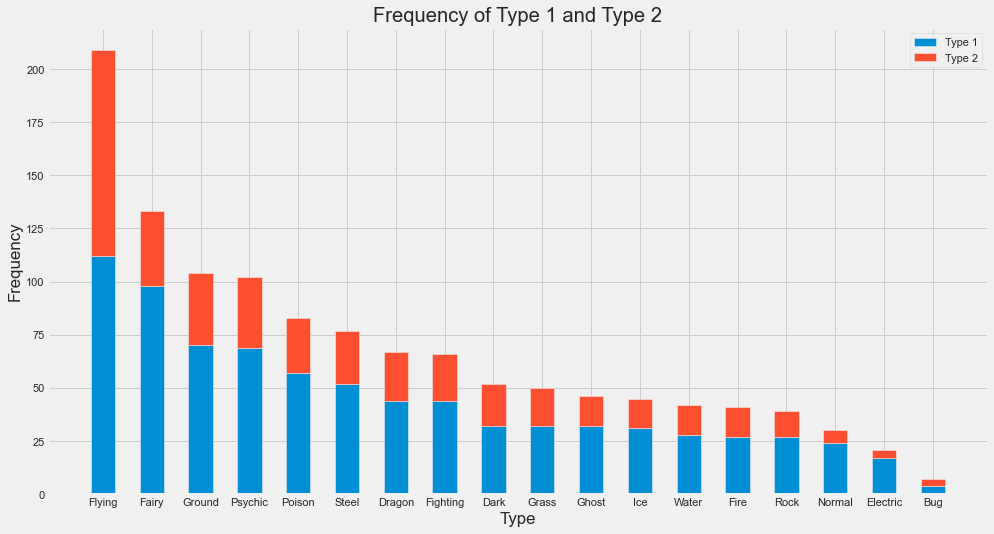

In [391]:
N = 18
types = ['Flying', 'Fairy', 'Ground', 'Psychic', 'Poison', 'Steel', 'Dragon', 
                   'Fighting', 'Dark', 'Grass', 'Ghost', 'Ice', 'Water', 'Fire', 'Rock', 
                   'Normal', 'Electric', 'Bug']
ind = np.arange(N)
fig, ax = plt.subplots(figsize=(15,8))
p1 = ax.bar(ind, pokemon['Type 1'].value_counts(), .5, label = 'Type 1')
p2 = ax.bar(ind, pokemon['Type 2'].value_counts(), .5, bottom = pokemon['Type 1'].value_counts(), label = 'Type 2')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Frequency')
ax.set_xlabel('Type')
ax.set_title('Frequency of Type 1 and Type 2')
ax.set_xticks(ind)
ax.set_xticklabels((types))
ax.legend()

plt.show()

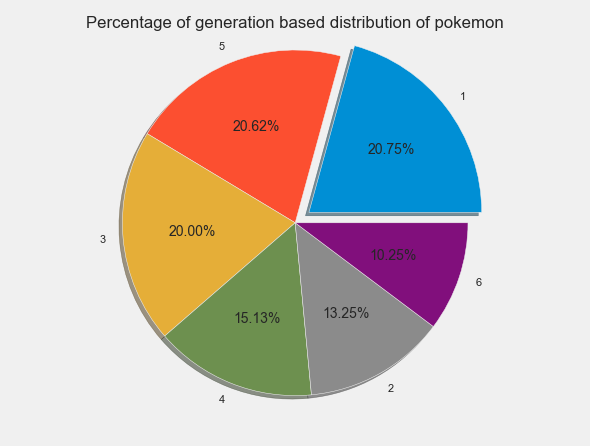

In [392]:
generation =  dict(pokemon['Generation'].value_counts())
gen_counts = generation.values() # No of pokemon in each generation
gen = generation.keys()  # Type of generation

fig = plt.figure(figsize=(8, 6))
fig.suptitle("Percentage of generation based distribution of pokemon")
ax = fig.add_axes([0,0,1,1])
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
ax.axis('equal')

plt.pie(gen_counts, labels = gen,autopct='%1.2f%%', shadow=True, explode=explode)
plt.show()

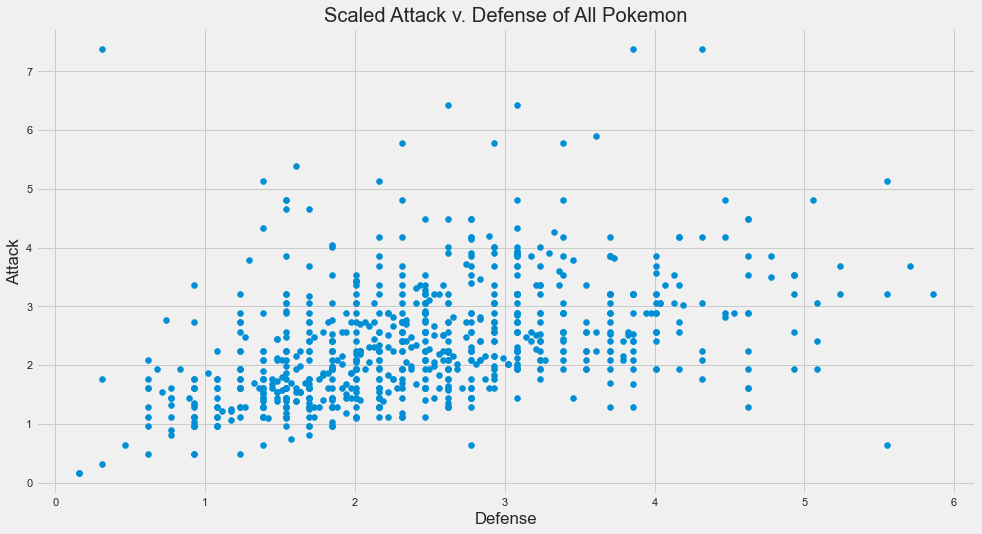

In [393]:
pokemon['att_scaled'] = whiten(pokemon['Attack'])
pokemon['def_scaled'] = whiten(pokemon['Defense'])

att_col = pokemon.loc[:,"att_scaled"]
def_col = pokemon.loc[:,"def_scaled"]

plt.figure(figsize = (15,8))
plt.scatter(att_col, def_col)
plt.ylabel('Attack')
plt.xlabel('Defense')
plt.title("Scaled Attack v. Defense of All Pokemon")
plt.show()

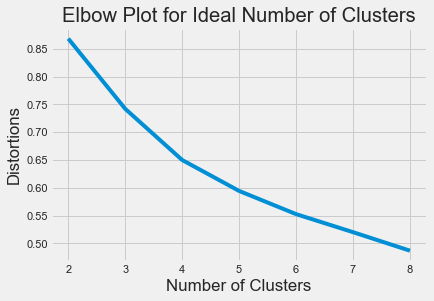

In [394]:
distortions = []
num_clusters = range(2, 9)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(pokemon[['att_scaled', 'def_scaled']],i)
    distortions.append(distortion)

# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xlabel("Number of Clusters")
plt.ylabel("Distortions")
plt.xticks(num_clusters)
plt.title("Elbow Plot for Ideal Number of Clusters")
plt.show()

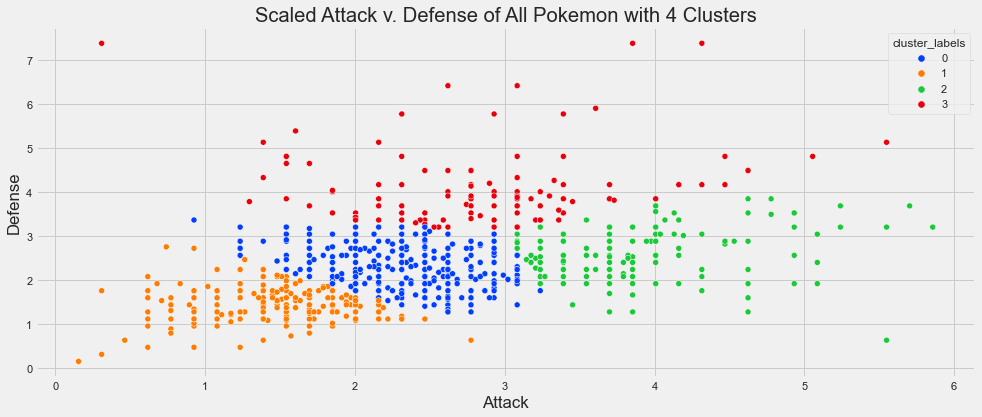

In [395]:
cluster_centers, distortion = kmeans(pokemon[['att_scaled', 'def_scaled']],4)
pokemon['cluster_labels'], distortion_list = vq(pokemon[['att_scaled', 'def_scaled']], cluster_centers)

plt.figure(figsize = (15,6))
sns.scatterplot(x = 'att_scaled', y='def_scaled', hue = 'cluster_labels', palette = 'bright', data = pokemon)
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.title("Scaled Attack v. Defense of All Pokemon with 4 Clusters")
plt.show()

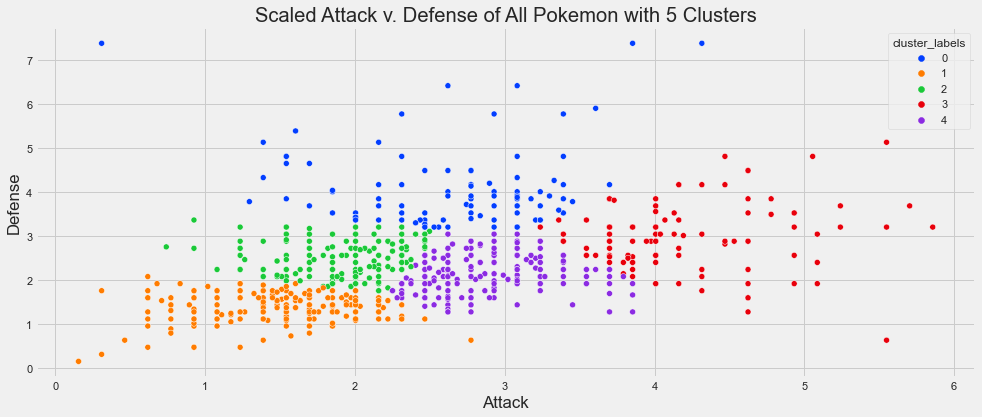

In [396]:
cluster_centers, distortion = kmeans(pokemon[['att_scaled', 'def_scaled']],5)
pokemon['cluster_labels'], distortion_list = vq(pokemon[['att_scaled', 'def_scaled']], cluster_centers)

plt.figure(figsize = (15,6))
sns.scatterplot(x = 'att_scaled', y='def_scaled', hue = 'cluster_labels', palette = 'bright', data = pokemon)
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.title("Scaled Attack v. Defense of All Pokemon with 5 Clusters")
plt.show()

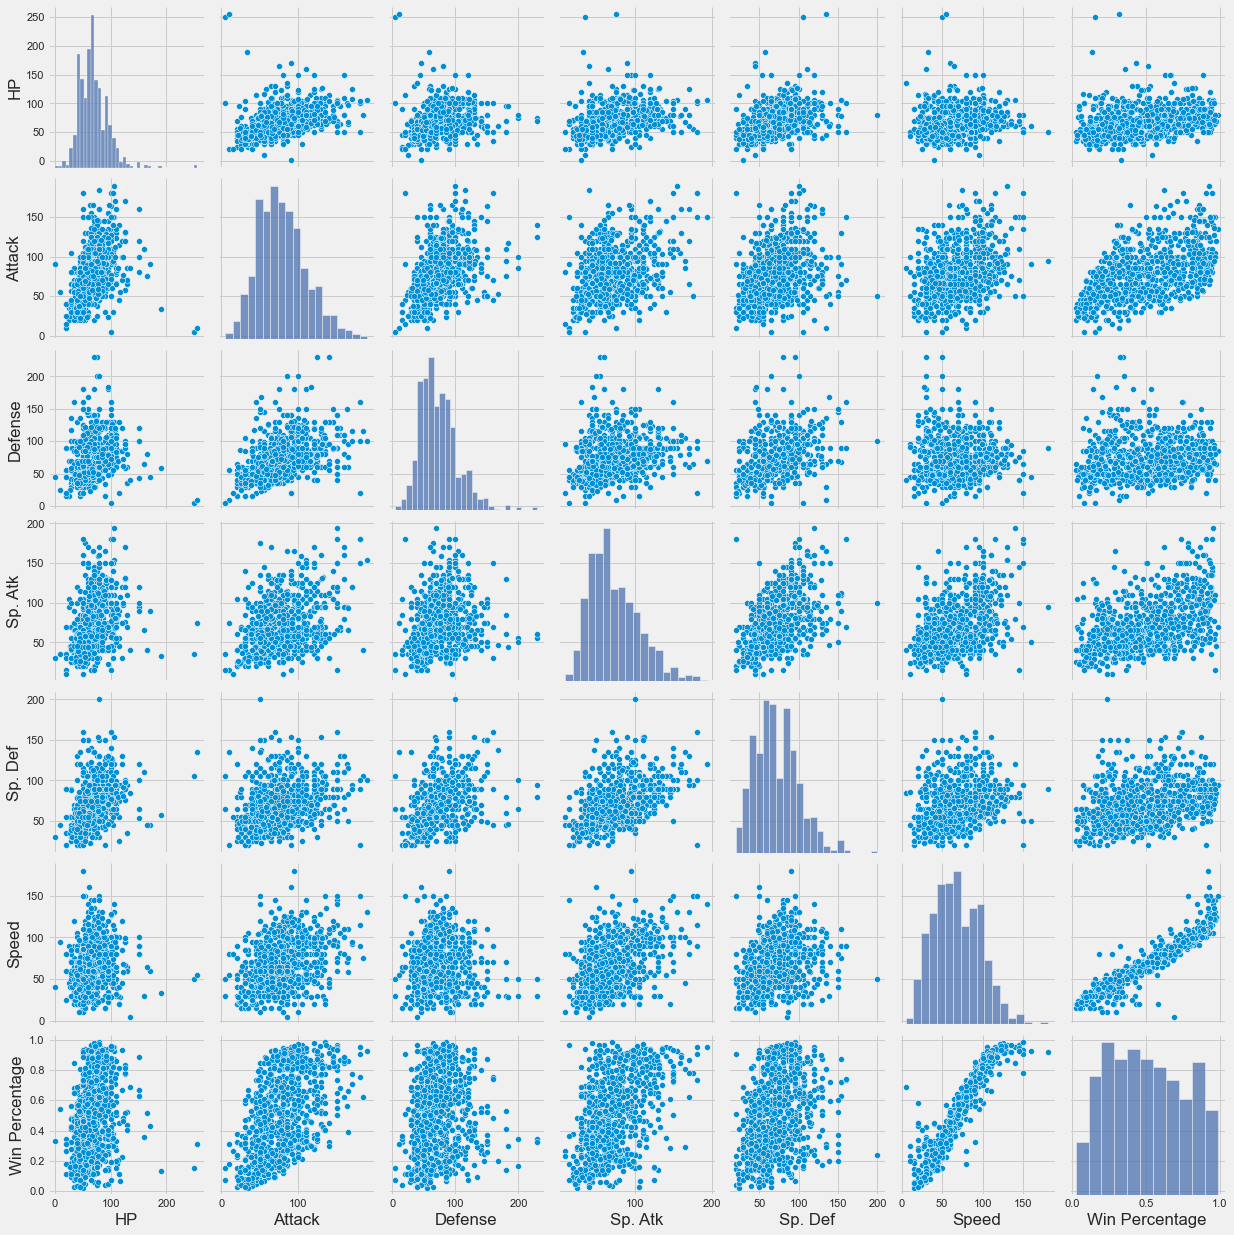

In [397]:
#sns.distplot(results3["Win Percentage"].dropna(), bins=20)
col = ['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win Percentage']
#results3.loc[:,'HP':'Speed'].corr()
sns.pairplot(results3.loc[:,col].dropna())

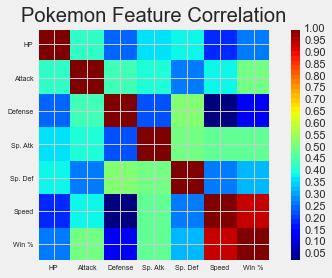

In [398]:
results3.loc[:,col].corr()
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 50)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Pokemon Feature Correlation')
    labels=['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win %']
    ax1.set_xticklabels(labels,fontsize=7)
    ax1.set_yticklabels(labels,fontsize=7)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.00,.05,.10,.15,.20,.25,.30,.35,.40,.45,.50,.55,.60,.65,.70,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(results3.loc[:,col])

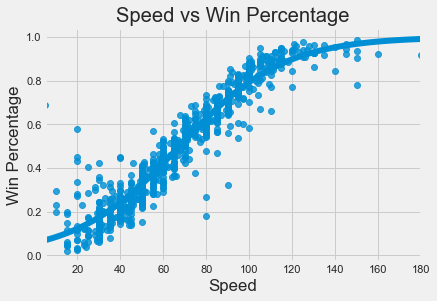

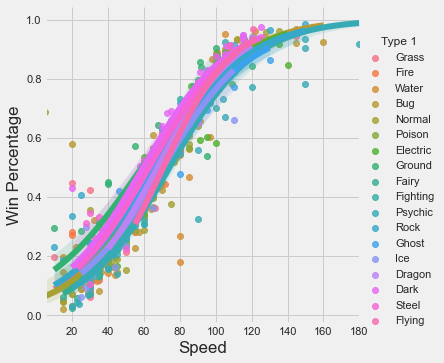

In [399]:
import matplotlib.pyplot as plt
#f, (ax1, ax2) = plt.subplots(1,2)
sns.regplot(x="Speed", y="Win Percentage", data=results3, logistic=True).set_title("Speed vs Win Percentage")
sns.lmplot(x="Speed", y="Win Percentage", data=results3, hue = 'Type 1',  logistic=True)#.set_title("Speed vs Win Percentage")

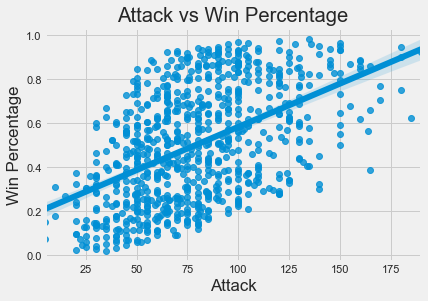

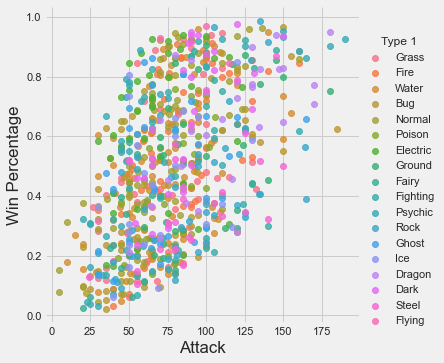

In [400]:
ax = sns.regplot(x="Attack", y="Win Percentage", data=results3).set_title("Attack vs Win Percentage")
sns.lmplot(x="Attack", y="Win Percentage", data=results3, hue = 'Type 1',fit_reg =False)

Now we turn our attention to prediction of future battles.

In [401]:
pokemon.drop(['Name','Type 2','HP','att_scaled', 'def_scaled', 'cluster_labels'],axis=1,inplace=True)
pokemon['Type 1'].value_counts().index

Index(['Water', 'Normal', 'Grass', 'Bug', 'Psychic', 'Fire', 'Rock',
       'Electric', 'Ghost', 'Dragon', 'Ground', 'Dark', 'Poison', 'Fighting',
       'Steel', 'Ice', 'Fairy', 'Flying'],
      dtype='object')

In [402]:
pokemon['Type 1'].replace(types, list(range(1,19)),inplace=True)

In [403]:
pokemon['Legendary'].value_counts().index

Index([False, True], dtype='object')

<AxesSubplot:>

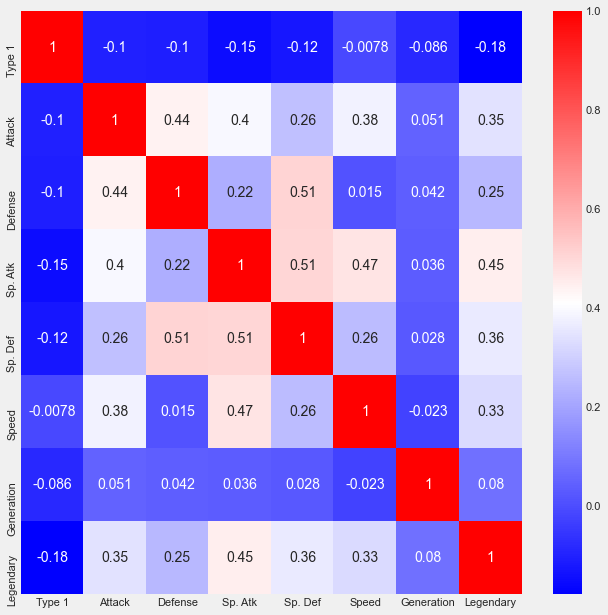

In [404]:
plt.figure(figsize=(10,10))
pokemon['Legendary']=pokemon['Legendary'].map({False:0,True:1})
sns.heatmap(pokemon.corr(),annot=True,cmap = "bwr",)

In [405]:
target = 'Legendary' #Set a target
x_columns = [x for x in pokemon.columns if x not in [target]]
X=pokemon[x_columns]
Y=pokemon['Legendary']

In [406]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.4, random_state = 39)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((480, 7), (480,), (320, 7), (320,))

In [413]:
C_loop = [0.001, 0.01, 0.1, 1]
for i in C_loop:
    model=svm.SVC(kernel='linear', C= i, gamma=.1)
    model.fit(x_train,y_train)
    prediction2 = model.predict(x_test)
    print('Accuracy for linear SVM with C =', i, ' is', metrics.accuracy_score(prediction2,y_test))

Accuracy for linear SVM with C = 0.001  is 0.95625
Accuracy for linear SVM with C = 0.01  is 0.959375
Accuracy for linear SVM with C = 0.1  is 0.965625
Accuracy for linear SVM with C = 1  is 0.965625


In [408]:
model=KNeighborsClassifier() 
model.fit(x_train,y_train)
prediction5=model.predict(x_test)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,y_test))

The accuracy of the KNN is 0.9375


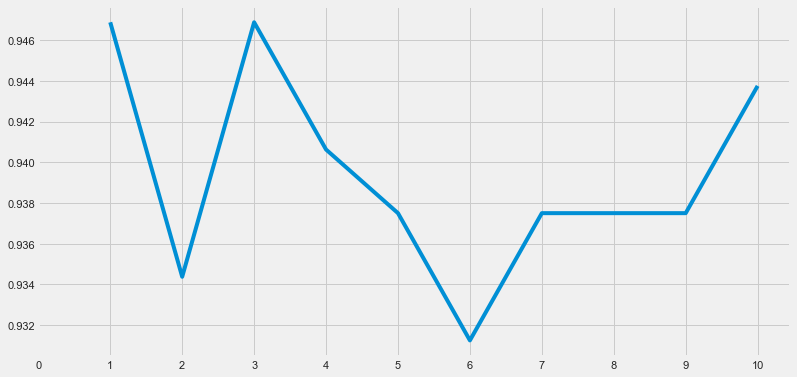

Accuracies for different values of n are:
 [0.946875 0.934375 0.946875 0.940625 0.9375   0.93125  0.9375   0.9375
 0.9375   0.94375 ] 
with the max value at  0.946875


In [409]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(x_train,y_train)
    prediction=model.predict(x_test)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,y_test)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:\n',a.values,'\nwith the max value at ',a.values.max())

In [416]:
model=RandomForestClassifier(n_estimators=10000)
model.fit(x_train,y_train)
prediction7=model.predict(x_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,y_test))

The accuracy of the Random Forests is 0.959375


In [420]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
# from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=39) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]

classifiers=['Linear Svm','Logistic Regression','KNN','Random Forest']
models=[svm.SVC(kernel='linear'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),
        RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.94625,0.045775
Logistic Regression,0.94375,0.045843
KNN,0.92750,0.063443
Random Forest,0.94000,0.055565


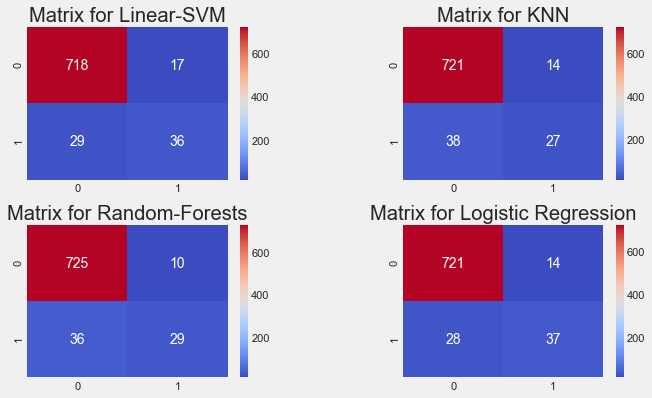

In [412]:
from sklearn.model_selection import cross_val_predict
f,ax=plt.subplots(2,2,figsize=(10,6))
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f',cmap='coolwarm')
ax[0,0].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f',cmap='coolwarm')
ax[0,1].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f',cmap='coolwarm')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f',cmap='coolwarm')
ax[1,1].set_title('Matrix for Logistic Regression')
plt.subplots_adjust(hspace=0.3,wspace=0.5)
plt.show()